In [94]:
import json
import astropy.units as u
import matplotlib.pyplot as plt

from gammapy.datasets import MapDataset
from gammapy.modeling.models import Models
from gammapy.estimators import ExcessMapEstimator, FluxPoints

from GPyUtils.models_templates import MyCatalog
from modules.variables import *

# Specify the folder containing your JSON files
diffuse = 'no_diffuse'
file_name = 'all_IDs'
strategy = 1
tol = 0.1
e_min = 0.7
e_max = 100
bin = 20
binsz = 0.05

In [95]:
# Set the path to the dataset file
dataset_name = f"dataset_{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}.fits.gz"
path_to_dataset = path_to_datasets / 'width_22x10' / dataset_name

# Reading the MapDataset from the specified file
dataset = MapDataset.read(filename=path_to_dataset)

In [96]:
# Load the fitted model from the YAML file
path_to_fit_models = path_to_results / 'single_model' / f'strategy_{strategy}' / f'tol_{tol}' / diffuse / f"{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}" / "models"
path = list(path_to_fit_models.rglob("02*.yaml"))
models_fit = Models.read(path[0])

# Set the loaded model as the source model in the dataset
dataset.models = models_fit
cygnus_diffuse_spatial_model = dataset.models["cygnus_diffuse"].spatial_model

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [97]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[1, 5, 10, 20, 50, 100, 200] * u.TeV,
)

/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/tutone/Installed/anaconda3/envs/gammapy-1.0/lib/python3.9/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


array([[<WCSAxes: title={'center': 'Energy 897 GeV - 5.09 TeV'}>,
        <WCSAxes: title={'center': 'Energy 5.09 TeV - 10.7 TeV'}>,
        <WCSAxes: title={'center': 'Energy 10.7 TeV - 22.6 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 22.6 TeV - 47.5 TeV'}>,
        <WCSAxes: title={'center': 'Energy 47.5 TeV - 100.0 TeV'}>,
        <WCSAxes: >]], dtype=object)

<Figure size 2000x1000 with 0 Axes>

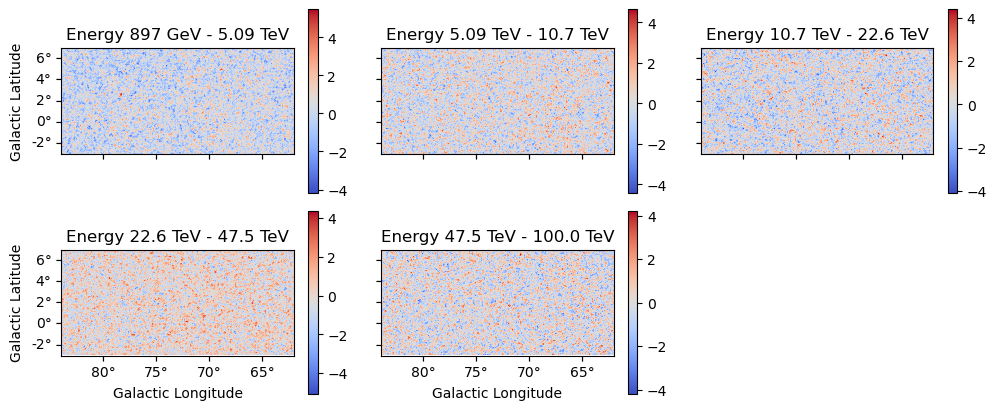

In [98]:
result = estimator.run(dataset)
plt.figure(figsize=(20,10))
result["sqrt_ts"].plot_grid(
    figsize=(12,5), cmap="coolwarm", add_cbar=True, ncols=3
)

(0.7, 200)

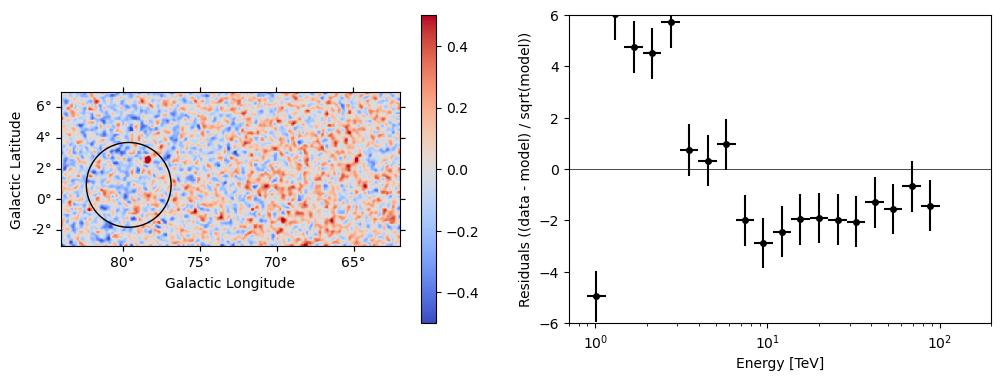

In [99]:
region = cygnus_diffuse_spatial_model.to_region()

ax = dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region, color="black", method="diff/sqrt(model)")
)
ax[1].set_ylim([-6,6])
ax[1].set_xlim([0.7,200])

In [100]:
path_to_result_fluxpoints = path_to_fluxdatapoints / 'single_model' / f'strategy_{strategy}' / f'tol_{tol}' / diffuse / f"{file_name}_ene_{e_min}_{e_max}_bin_{bin}_binsz_{binsz}"
filename = path_to_result_fluxpoints / f"{path[0].with_suffix('').name}.fits"
diffuse_flux_points = FluxPoints.read(filename)

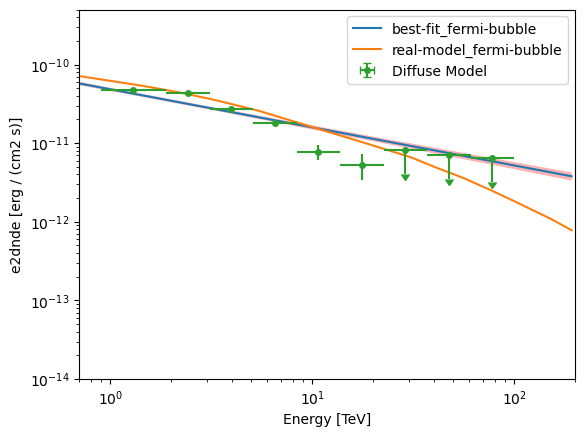

In [101]:
# Template emission for the Fermi Bubble
mycat = MyCatalog()
fermi_template = mycat.fermi_bubble()[0].spectral_model
fitted_diffuse = dataset.models["cygnus_diffuse"].spectral_model

fig, ax = plt.subplots()

plot_kwargs = {
    "energy_bounds": [0.1, 200] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "ax": ax,
}

# plot best fit model
fitted_diffuse.plot(**plot_kwargs, label="best-fit_fermi-bubble")
fitted_diffuse.plot_error(facecolor="red", alpha=0.3, **plot_kwargs)


# plot joint model
ax = fermi_template.plot(**plot_kwargs, label="real-model_fermi-bubble")

#plot flux data points
#diffuse_flux_points.plot(ax=ax, sed_type="e2dnde", label="Real Model")
diffuse_flux_points.plot(ax=ax, sed_type="e2dnde",label="Diffuse Model")

ax.set_ylim([1.e-14, 5.e-10])
ax.set_xlim([0.7, 200])
ax.legend()
plt.show()